In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset

In [ ]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [ ]:
train_data.head()

fps_mean   fps_std  fps_lags  rtt_mean    rtt_std  dropped_frames_mean  \
0      24.4  0.516398         0      91.1   6.723921                  0.0   
1      28.6  2.065591         0      99.7  15.923777                  0.0   
2      30.0  0.000000         0      98.1  11.798776                  0.0   
3      30.3  0.948683         0      99.4  13.014522                  0.0   
4      29.9  0.316228         0     123.2  62.476307                  0.0   

   dropped_frames_std  dropped_frames_max auto_bitrate_state auto_fec_state  \
0                 0.0                 0.0                off        partial   
1                 0.0                 0.0                off        partial   
2                 0.0                 0.0                off        partial   
3                 0.0                 0.0                off        partial   
4                 0.0                 0.0                off        partial   

   auto_fec_mean  stream_quality  
0           50.0               0  
1           50.0               0  
2           50.0               0  
3           50.0               0  
4           50.0               0

In [ ]:
train_data.describe()

fps_mean        fps_std       fps_lags       rtt_mean  \
count  406572.000000  406572.000000  406572.000000  406572.000000   
mean       34.497561       2.285486       0.183151      54.314400   
std        11.625494       3.708531       1.099384     133.872062   
min         0.000000       0.000000       0.000000       0.000000   
25%        28.300000       0.316228       0.000000      14.100000   
50%        30.000000       0.994429       0.000000      32.300000   
75%        43.000000       2.590581       0.000000      57.100000   
max       127.100000     312.540842      10.000000   12898.400000   

             rtt_std  dropped_frames_mean  dropped_frames_std  \
count  406572.000000         4.065720e+05        4.065720e+05   
mean       19.525019         1.730432e+06        1.378279e+05   
std       156.364337         4.930091e+07        9.229776e+06   
min         0.000000         0.000000e+00        0.000000e+00   
25%         0.699206         0.000000e+00        0.000000e+00   
50%         1.490712         0.000000e+00        0.000000e+00   
75%         5.334375         0.000000e+00        0.000000e+00   
max     40721.933293         2.097289e+09        9.963751e+08   

       dropped_frames_max  auto_fec_mean  stream_quality  
count        4.065720e+05  406572.000000   406572.000000  
mean         1.893339e+06      51.413536        0.068460  
std          5.241003e+07      34.836045        0.252534  
min          0.000000e+00       0.000000        0.000000  
25%          0.000000e+00      50.000000        0.000000  
50%          0.000000e+00      50.000000        0.000000  
75%          0.000000e+00      50.000000        0.000000  
max          2.097289e+09     250.000000        1.000000

We can see the wide margin between different columns. This shows that our data needs to be standardized.

## Profiling

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(train_data)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Analysis based on profiling

1.   Existence of duplicate items that can be dropped.
2.   Existence of categorical variables that needs to be transformed.
3.  Existence of correlated features that require further processing to determine if they need to be dropped.
4. fps values are correlated with our target variable
5. No missing cells hence no need to impute



# Preprocessing

## Dropping Duplicates

In [ ]:
train_data.drop_duplicates(inplace=True)

## Extracting Target

In [ ]:
train_target = train_data['stream_quality']
train_data.drop('stream_quality', axis=1, inplace=True)
test_target = test_data['stream_quality']
test_data.drop('stream_quality', axis=1, inplace=True)

## Encoding Categorical variables

In [ ]:
from category_encoders import OneHotEncoder
encoder = OneHotEncoder(cols=["auto_bitrate_state", "auto_fec_state"]).fit(train_data)

In [ ]:
train_data = encoder.transform(train_data)
test_data = encoder.transform(test_data)

## Scaling Data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns = train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns = test_data.columns)

## Feature Selection

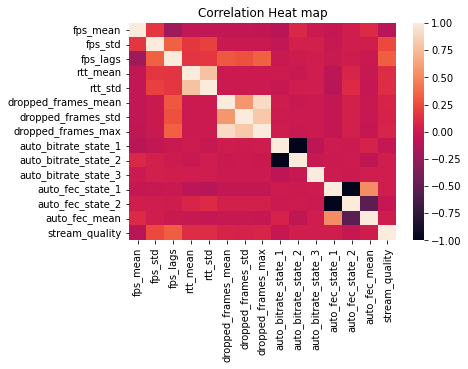

In [ ]:
#Multicollinearity
import seaborn as sb
sb.heatmap(train_data.corr())
plt.title("Correlation Heat map")
plt.show()

We have a high correlation between 

*   fps_lags, fps_mean and fps_std
*   dropped_frames_mean, dropped_frames_std and dropped_frames_max
*   rtt_mean and rtt_std
*   auto_fec_state and auto_fec_mean

we use the variance_inflation_factor to check for multicollinearity



### Variance Inflation Factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def compute_vif(considered_features, df):
    x = df[considered_features]
    x['intercept'] = 1
    vif = pd.DataFrame()
    vif['Variable'] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [ ]:
features_to_be_eliminated = ['fps_lags','fps_mean','fps_std','dropped_frames_mean','dropped_frames_std','dropped_frames_max','rtt_mean', 'rtt_std','auto_fec_mean']
compute_vif(features_to_be_eliminated,train_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Variable        VIF
0             fps_lags   1.403637
1             fps_mean   1.127752
2              fps_std   1.252445
3  dropped_frames_mean  11.147963
4   dropped_frames_std   5.998614
5   dropped_frames_max  22.925134
6             rtt_mean   2.612534
7              rtt_std   2.653517
8        auto_fec_mean   1.011684

We can dropped_frames_max as it has a considerably large VIF value

In [ ]:
train_data.drop('dropped_frames_max', axis=1, inplace=True)
test_data.drop('dropped_frames_max', axis=1, inplace=True)

In [ ]:
features_to_be_eliminated = ['fps_lags','fps_mean','fps_std','dropped_frames_mean','dropped_frames_std','rtt_mean', 'rtt_std','auto_fec_mean']
compute_vif(features_to_be_eliminated,train_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Variable       VIF
0             fps_lags  1.391672
1             fps_mean  1.127594
2              fps_std  1.250904
3  dropped_frames_mean  1.547636
4   dropped_frames_std  1.517052
5             rtt_mean  2.612403
6              rtt_std  2.653517
7        auto_fec_mean  1.011657

# Data Visualisation

## PairPlot

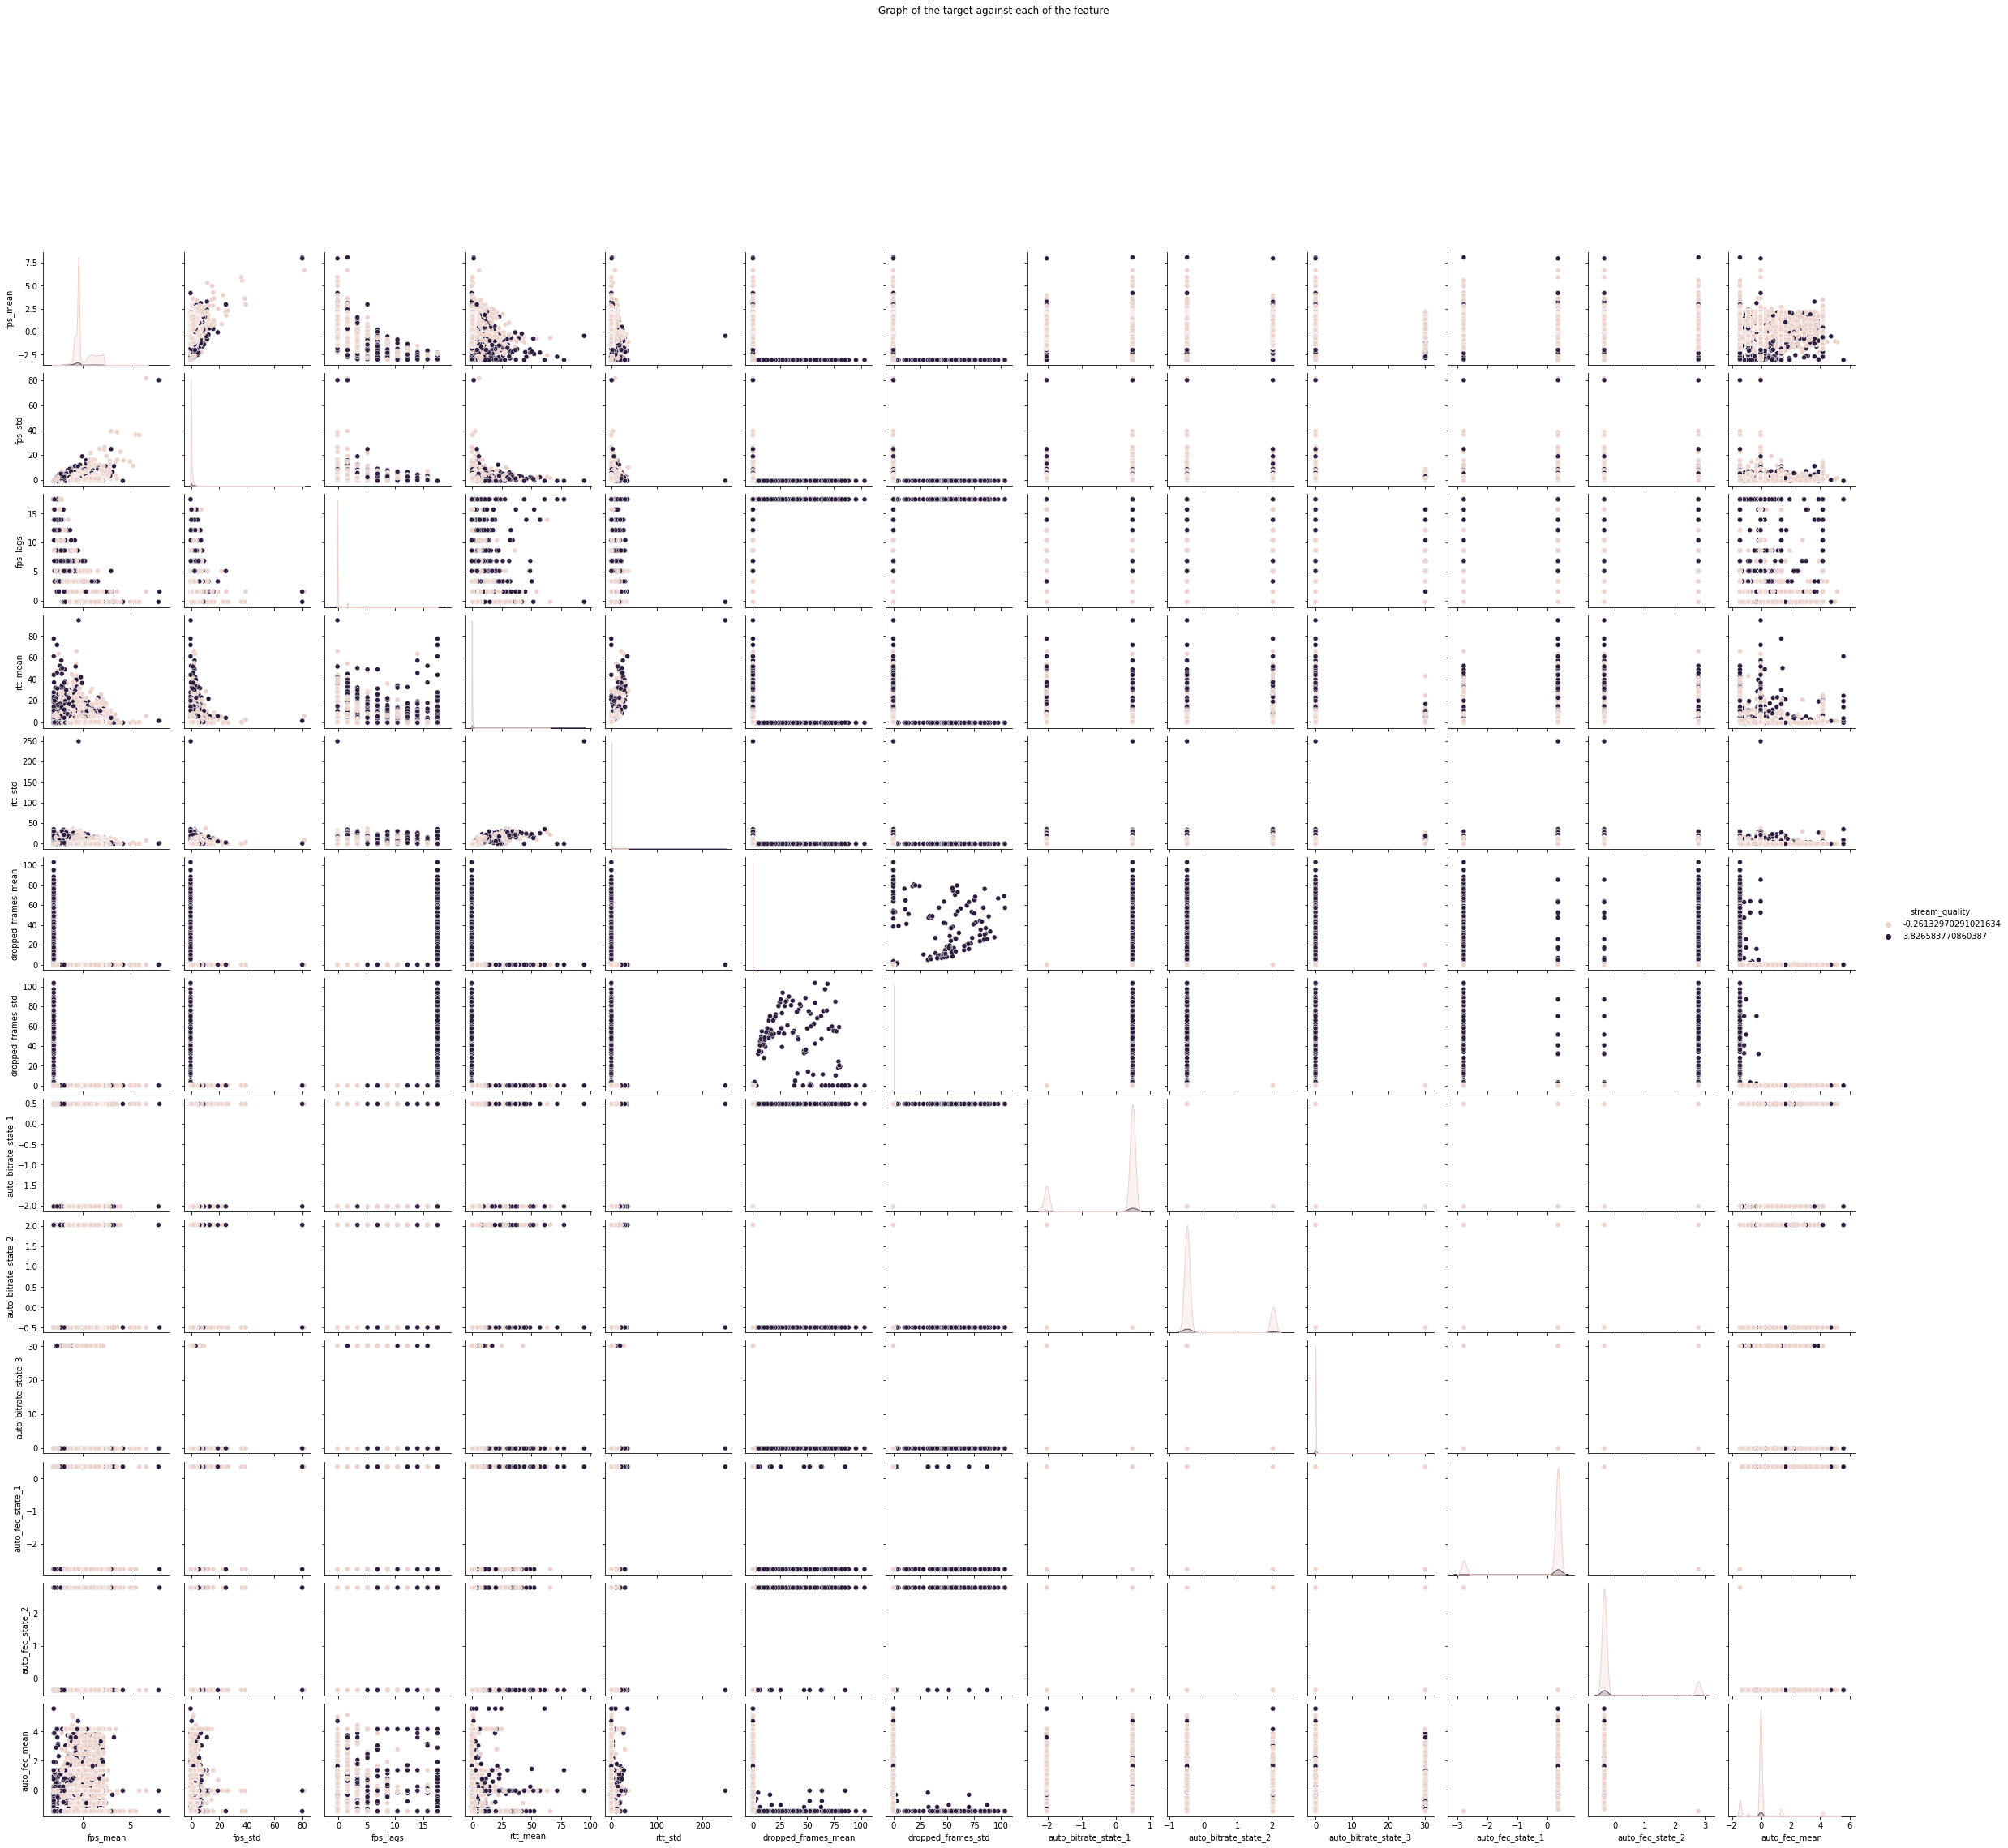

In [ ]:
p = sb.pairplot(train_data, hue='stream_quality')
p.fig.suptitle('Graph of the target against each of the feature')
plt.subplots_adjust(top=0.85)
plt.show()

## PCA
using pca to visualise if there exist 2 unique groups.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_PCA = pca.fit_transform(train_data)

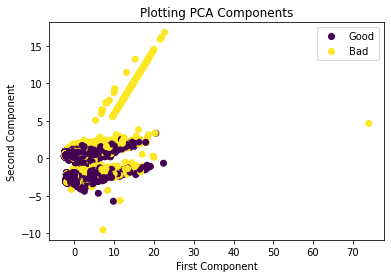

In [ ]:
scatter = plt.scatter(X_PCA[:,0], X_PCA[:,1], c = train_target)
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.title("Plotting PCA Components")
plt.legend(handles=scatter.legend_elements()[0], labels=["Good","Bad"])
plt.show()

The first two components of the  pca doesn't show a clear separation between the two classes.
But we can see certain outliers that exist outside our classes. This suggests that we might need to do some outlier detection


In [ ]:
print(pca.explained_variance_ratio_)

[0.19014413 0.15562698]


From the explained_variance_ratio we can see that the first set of principal components doesn't account for a large amount of variance in the data as the difference between the values of the variance

# Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

We use a simple logistic regression to see whether it works for our data

In [ ]:
log_regression = LogisticRegression(penalty='l1', solver='liblinear')
log_regression.fit(train_data, train_target)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
log_reg_train_pred = log_regression.predict(train_data)
log_reg_test_pred = log_regression.predict(test_data)

In [ ]:
print('The mean training accuracy is {}'.format(log_regression.score(train_data, train_target)))
print('The mean test accuracy is {}'.format(log_regression.score(test_data, test_target)))

The mean training accuracy is 0.9402452685572784
The mean test accuracy is 0.9403972150610026


We get high training and test score.
This shows that our model is neither overfitting and underfitting

## Performance Measurement

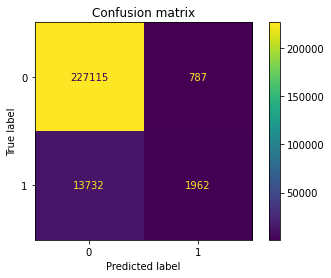

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_target, log_reg_test_pred)
plt.title("Confusion matrix")
plt.show()

From the confusion_matrix, we can see a large number of true positive compared to other values, this shows us that our model accurately predics the straam quality to be good a large number of times. 
Although, It also has a considerably large number of false positives, This might be due to the large number of Positively labeled values in our training dataset.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_target, log_reg_test_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    227902
           1       0.71      0.13      0.21     15694

    accuracy                           0.94    243596
   macro avg       0.83      0.56      0.59    243596
weighted avg       0.93      0.94      0.92    243596





*   From the precision values, we can see that 95% of the instances classified as good stream quality are actually correct while 85% of the instances classified as bad stream quality are correct.
*   Our high recall value for stream quality shows us that our model identifies good stream quality almost 100% of the time while it identifies bad stream quality 71% of the time. The low recall value shows that when the stream quality is bad, the model will predict it 13% of the time. This might be due to the large amount of data for good streaming skewing our result
* Our low f1_score directly follows from the low recall value



# Outliers

##  Detecting outliers  using local outlier factor

In [ ]:
#Removing outliers
from sklearn.neighbors import LocalOutlierFactor
lofResult = LocalOutlierFactor().fit_predict(train_data)

In [ ]:
np.unique(lofResult, return_counts=True)

(array([-1,  1]), array([ 15062, 358080]))

Our algorithm finds over 12916 outliers

## Removing outliers

In [ ]:
train_data_no_outlier, train_target_no_outlier = train_data[lofResult == 1],  train_target[lofResult == 1]

In [ ]:
log_regression = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
log_regression.fit(train_data_no_outlier, train_target_no_outlier)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

## Performance Measurement

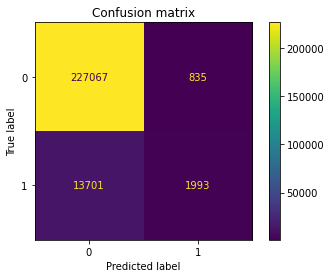

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    227902
           1       0.70      0.13      0.22     15694

    accuracy                           0.94    243596
   macro avg       0.82      0.56      0.59    243596
weighted avg       0.93      0.94      0.92    243596



In [ ]:
log_reg_test_pred = log_regression.predict(test_data)

ConfusionMatrixDisplay.from_predictions(test_target, log_reg_test_pred)
plt.title("Confusion matrix")
plt.show()

print(classification_report(test_target, log_reg_test_pred))

Removal of outliers has little effect on our model.

# Balancing Dataset

Combine SMOTE Over sampling with ENN undersampling

In [ ]:
from imblearn.combine import SMOTEENN
cnn = SMOTEENN()
X_resampled, y_resampled = cnn.fit_resample(train_data_no_outlier, train_target_no_outlier)

In [ ]:
np.unique(y_resampled, return_counts=True)

(array([0, 1]), array([246636, 282251]))

We have a much more balanced dataset with the number of bad signals much more than the number of good signals.

In [ ]:
log_regression = LogisticRegression(penalty='l1', solver='liblinear')
log_regression.fit(X_resampled, y_resampled)

LogisticRegression(penalty='l1', solver='liblinear')

## Performance Measurement

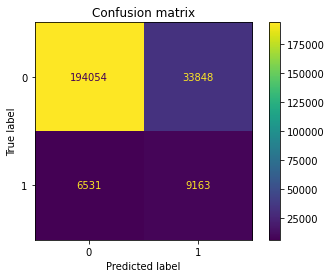

              precision    recall  f1-score   support

           0       0.97      0.85      0.91    227902
           1       0.21      0.58      0.31     15694

    accuracy                           0.83    243596
   macro avg       0.59      0.72      0.61    243596
weighted avg       0.92      0.83      0.87    243596



In [ ]:
log_reg_test_pred = log_regression.predict(test_data)

ConfusionMatrixDisplay.from_predictions(test_target, log_reg_test_pred)
plt.title("Confusion matrix")
plt.show()

print(classification_report(test_target, log_reg_test_pred))

Our new results show that we obtain high recall value after balancing our datasets. T